The following example shows how to train a model. Get a list of training data csv file in the selected folder. Lessons learned so far:
- Training result is very sensitive to normalization. The normalization approach based on mean and variance does not work very well. Still need to manually set mean and variance.
- t-sne plot of adapter trace is an important flag of training result. 
- h net does not have to descent because phi net training strives to make it rise, while h net training itself tries to lower the loss
- Increase the h training frequency to fight against rising h 
- Increase alpha to push domain info to adapter
- Increase number of features to minimize MSE loss.
- ocassional small spike in cross entropy loss is possibly a sign that phi net become further domain invariant and may not be bad.
- at the late stage of training while both mse loss and cross entropy loss converge. May need to train h net every step to refine the optimization direction.
- Do not need to select the model at the end epoch. Select the epoch when the loss is reasonably low and stable. 
- RMS is a good indicator because it matches the least square form of loss function
- When the residual force is small, e.g. training disturbance force compensated by BEMT, disturbance normalization should scale up the label for better learning. 

Existing problem:
- The more classes, the harder to train. The difficulty comes from instability of loss_f and loss_c. alpha is hard to tune.
- t-sne gets worse as epoch grows and the cross entropy loss remains the same. 

In [1]:
import os
import matplotlib.pyplot as plt

import training_manager

current_dir = os.getcwd()
# training_subfolder = "wind_near_wall_bemt_in_control_train_x_only_wind"
# training_subfolder = "wind_near_wall_bemt_in_control_train_z_only_wind"
# training_subfolder = "wind_near_wall_bemt_in_control_train_xz_wind"
training_subfolder = "nf_training_back2back"
validation_subfolder = "nf_validation_back2back"

def generate_data_list(subfolder):
    """
    Generate a list of data files in the specified subfolder.
    """
    folder_path = os.path.join(os.path.dirname(current_dir), "data", "training", subfolder)
    file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    # Filter out files that do not end with .csv
    file_names = [f for f in file_names if f.endswith('.csv')]
    # add subfolder to the file names
    data_list = [os.path.join(subfolder, f) for f in file_names]
    return data_list

data_list = generate_data_list(training_subfolder)
print("Training Data List:")
for data in data_list:
    print(data)

validation_list = generate_data_list(validation_subfolder)
print("\nValidation Data List:")
for data in validation_list:
    print(data)

path1 = os.path.join(training_subfolder, "input_label_map_disturbance_force_label.yaml")
path2 = os.path.join(training_subfolder, "column_map.yaml")

Training Data List:
nf_training_back2back\custom_random3_baseline_10wind_converted.csv
nf_training_back2back\custom_random3_baseline_20wind_converted.csv
nf_training_back2back\custom_random3_baseline_30wind_converted.csv
nf_training_back2back\custom_random3_baseline_40wind_converted.csv
nf_training_back2back\custom_random3_baseline_50wind_converted.csv
nf_training_back2back\custom_random3_baseline_nowind_converted.csv

Validation Data List:
nf_validation_back2back\custom_figure8_baseline_100wind_converted.csv
nf_validation_back2back\custom_figure8_baseline_35wind_converted.csv
nf_validation_back2back\custom_figure8_baseline_70p20sint_converted.csv
nf_validation_back2back\custom_figure8_baseline_70wind_converted.csv
nf_validation_back2back\custom_figure8_baseline_nowind_converted.csv


- Make sure the input_label_map_disturbance_force_label.yaml is in the selected folder. This yaml defines which fields are model inputs and which fields are data labels. 
- Make sure the column_map.yaml is in the selected folder. This yaml maps data fields to the corresponding column in the csv files. This file can be auto-generated by `Simulation\simulation\training_data_user_guide.ipynb`
- If this is the first time to train on this data. The script will normalize the data and save the normalization parameters into a file.

Loading normalization params file from
..\data\training\nf_training_back2back\normalization_params.yaml
[1] loss_phi: 2.54 loss_h: 1.83 loss_validation: 0.80
a_trace: [[-0.22541981 -0.23903551 -0.03187157]
 [-0.23136649  0.01346181  0.26086942]
 [ 0.09660763  0.38963221  0.07123733]
 [-5.14163744  1.08266725 -8.4849539 ]]
[101] loss_phi: 1.23 loss_h: 1.80 loss_validation: 0.98
a_trace: [[-0.42234234 -0.64490204  0.19793893]
 [-5.17956414 -0.12624702  1.19179136]
 [-1.25457883  0.23170499  0.89272151]
 [-8.21162086  0.18188004  1.10179601]]
[201] loss_phi: 1.13 loss_h: 1.80 loss_validation: 0.59
a_trace: [[-0.20046613 -0.42675763 -0.01493709]
 [-2.36456608  0.03401669  2.80380021]
 [-3.01102272  0.29016099 -0.86482053]
 [-7.85857142  0.43788943  3.80481076]]
[301] loss_phi: 0.70 loss_h: 1.78 loss_validation: 0.35
a_trace: [[-0.35719426 -0.5372463   0.13713927]
 [ 1.5340332  -0.38653557  7.37435554]
 [-2.07858502 -0.35233957  3.73682074]
 [-4.60961907 -0.32285664  1.70876324]]
[401] loss

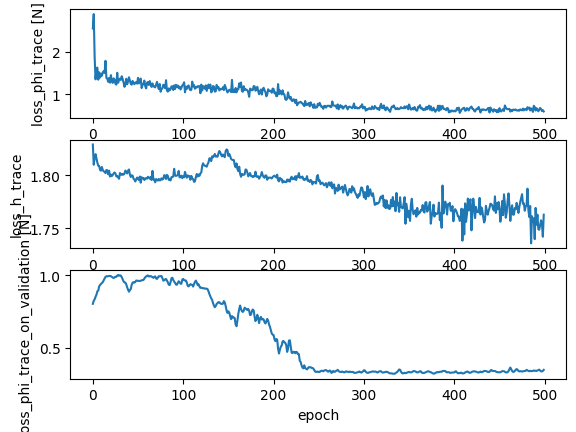

In [2]:
# use the data from previous section to train the model

manager = training_manager.TrainingPipeline()
manager.set_up(
    data_menu=data_list,
    # data_menu=data_list[:4],    # use small data list for quick testing
    input_label_map_file=path1,
    column_map_file=path2,
    can_skip_io_normalizaiton=False,
    can_inspect_data=False,
    validation_data_menu=validation_list[-1:]
)
plt.show() 
manager.train()
manager.trainer_instance.plot_loss()

plt.show()  

Inspect data in the data list.

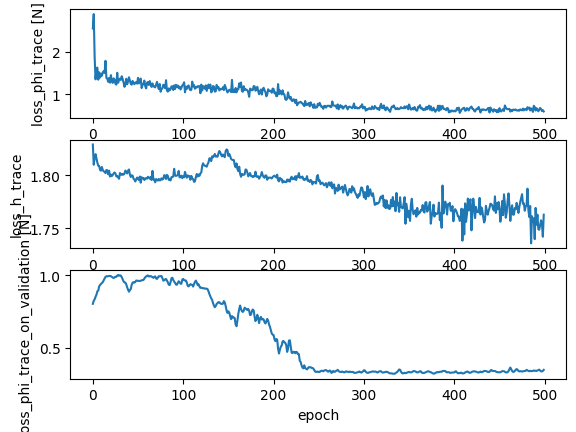

In [3]:
# trainer_instance.inspect_data(data_list[:2])
manager.trainer_instance.plot_loss()

Inspect t-sne of a_trace.

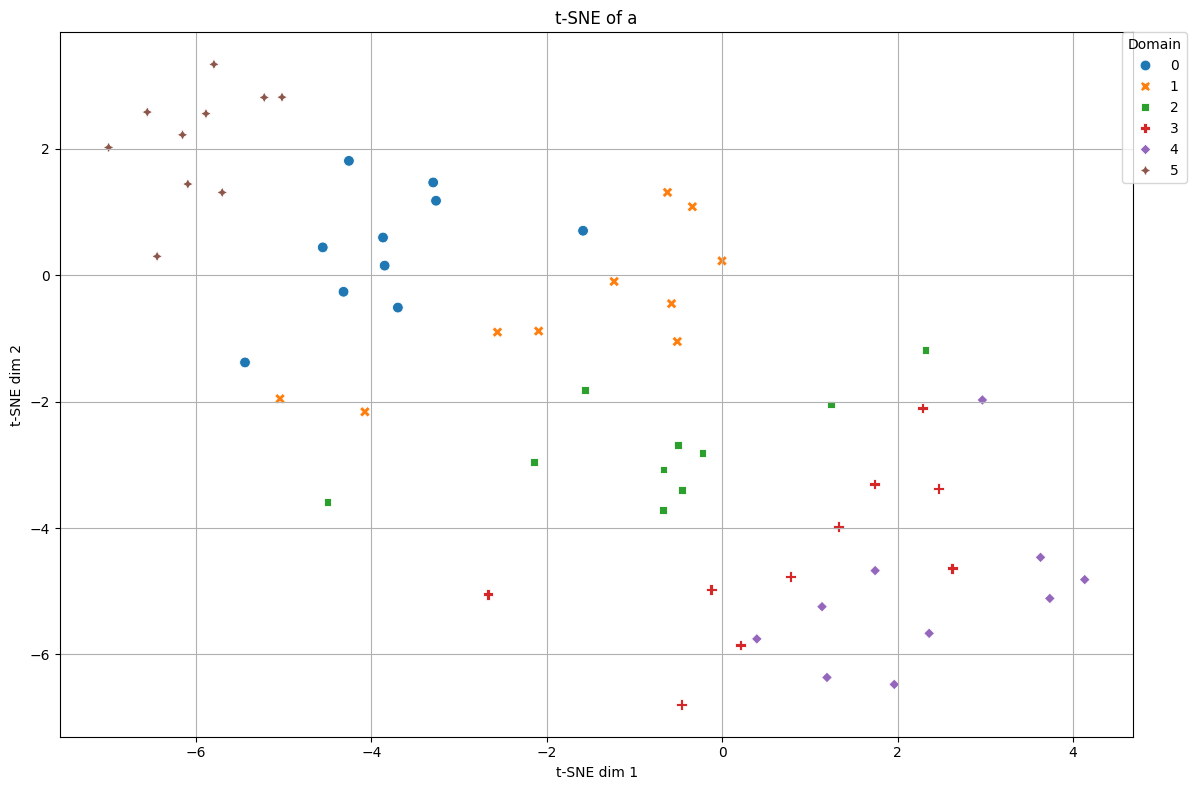

In [4]:
import performance_analyzer
can_print_3d = False
n = 100
performance_analyzer.plot_tsne_of_a(manager.trainer_instance.a_trace, list(range(n, n + 10)))
plt.show()  
if can_print_3d:
    %matplotlib tk
    performance_analyzer.plot_tsne_3d_of_a(manager.trainer_instance.a_trace, list(range(n, n + 10)))


After training, we can save the model in the following way.

In [5]:
model_name = training_subfolder
manager.save_model(model_name)

Model saved to model\nf_training_back2back.pth


Test the model using the test set.

test Data List:
nf_validation_back2back\custom_figure8_baseline_100wind_converted.csv
nf_validation_back2back\custom_figure8_baseline_35wind_converted.csv
nf_validation_back2back\custom_figure8_baseline_70p20sint_converted.csv
nf_validation_back2back\custom_figure8_baseline_70wind_converted.csv
nf_validation_back2back\custom_figure8_baseline_nowind_converted.csv
Loading normalization params file from
..\data\training\nf_training_back2back\normalization_params.yaml
phi net input output fields:
input ['q_0', 'q_1', 'q_2', 'q_3', 'v_0', 'v_1', 'v_2', 'pwm_0', 'pwm_1', 'pwm_2', 'pwm_3']
label ['fa_0', 'fa_1', 'fa_2']
phi_out: tensor([[ 1.0000,  0.4188, -0.1682,  0.0847],
        [ 1.0000,  0.4283, -0.1661,  0.0853],
        [ 1.0000,  0.4286, -0.1630,  0.0912],
        ...,
        [ 1.0000,  0.3652, -0.3455, -0.0654],
        [ 1.0000,  0.3552, -0.3540, -0.0771],
        [ 1.0000,  0.3487, -0.3586, -0.0836]])
a = tensor([[-3.1569e+01, -8.6797e-01, -1.3315e+01],
        [ 7.6396e+00, -4.70

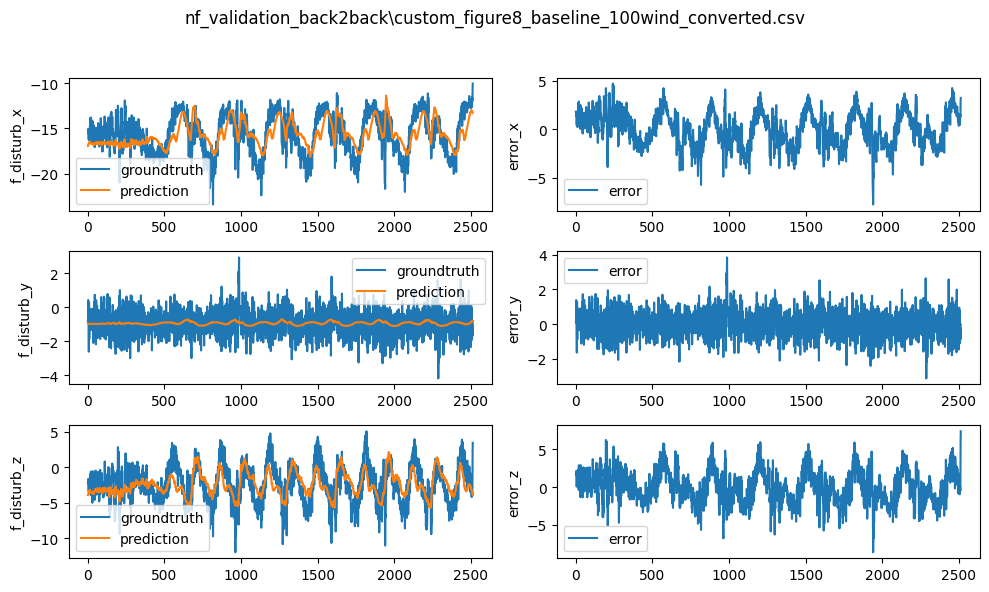

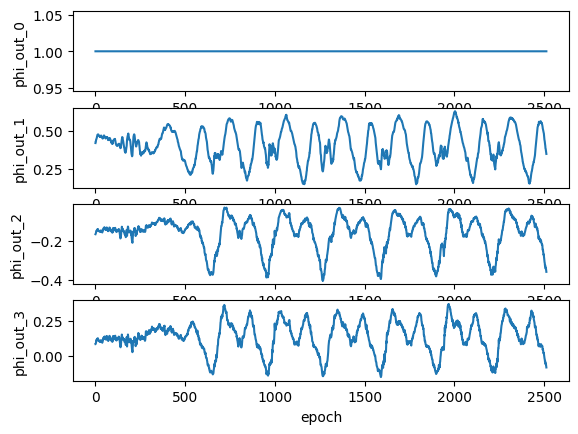

phi_out: tensor([[ 1.0000,  0.0584, -0.2095,  0.0734],
        [ 1.0000,  0.0578, -0.2049,  0.0822],
        [ 1.0000,  0.0554, -0.2001,  0.0908],
        ...,
        [ 1.0000,  0.0494, -0.3636, -0.0517],
        [ 1.0000,  0.0347, -0.3700, -0.0585],
        [ 1.0000,  0.0192, -0.3763, -0.0653]])
a = tensor([[-3.4956, -0.2875, -2.8929],
        [ 2.0289, -0.1438,  5.6023],
        [-2.4827,  0.4671, -8.8800],
        [-2.6766, -0.5859,  9.2340]])


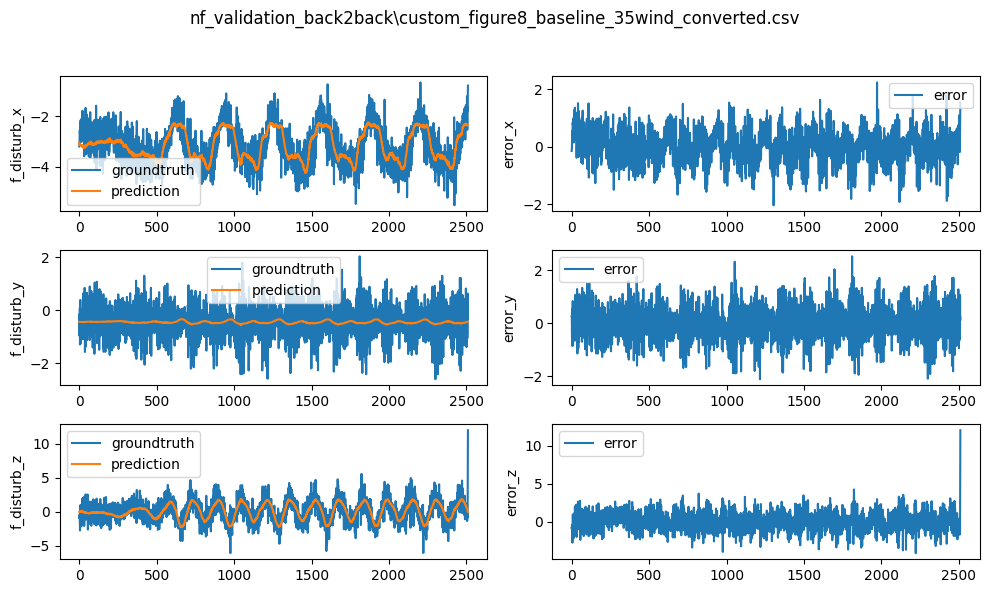

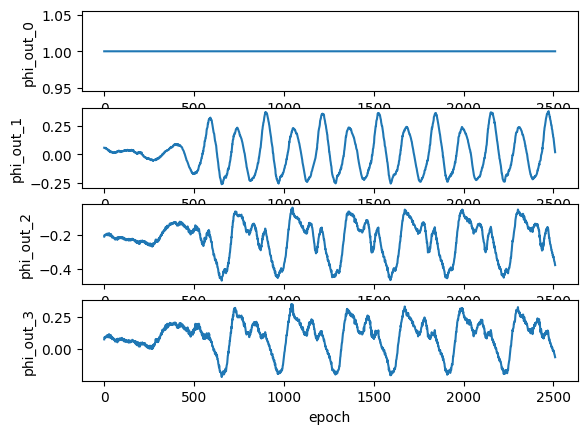

phi_out: tensor([[ 1.0000,  0.1175, -0.1941,  0.0959],
        [ 1.0000,  0.1201, -0.1915,  0.1004],
        [ 1.0000,  0.1204, -0.1887,  0.1043],
        ...,
        [ 1.0000,  0.0822, -0.3526, -0.0435],
        [ 1.0000,  0.0768, -0.3525, -0.0422],
        [ 1.0000,  0.0744, -0.3461, -0.0348]])
a = tensor([[-16.2366,  -0.7912, -10.6432],
        [ -1.0669,  -0.5037,   0.7635],
        [-31.7691,  -0.4156, -31.8552],
        [ 18.4312,   0.4200,  30.2095]])


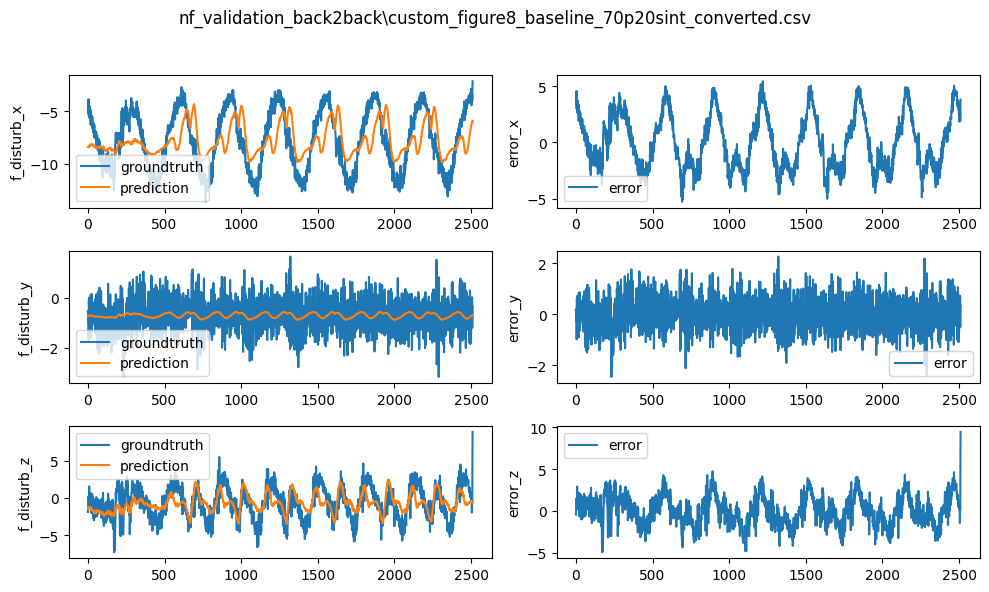

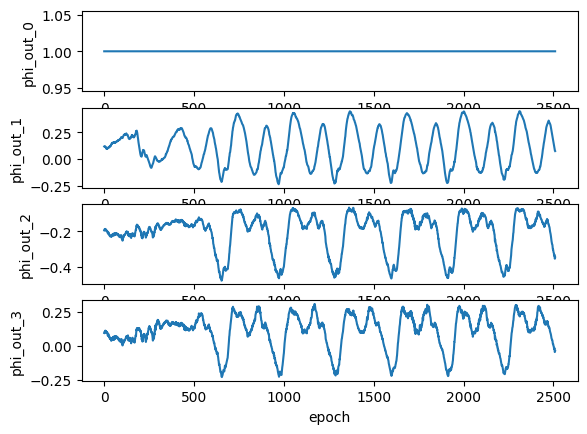

phi_out: tensor([[ 1.0000,  0.1285, -0.1871,  0.1065],
        [ 1.0000,  0.1260, -0.1857,  0.1102],
        [ 1.0000,  0.1252, -0.1832,  0.1190],
        ...,
        [ 1.0000,  0.1815, -0.3275, -0.0224],
        [ 1.0000,  0.1699, -0.3308, -0.0269],
        [ 1.0000,  0.1607, -0.3332, -0.0296]])
a = tensor([[-11.8007,   0.1304, -10.5009],
        [  4.2007,  -0.1745,   3.7076],
        [-18.0966,   1.9640, -29.8555],
        [  7.1882,  -1.9543,  28.0751]])


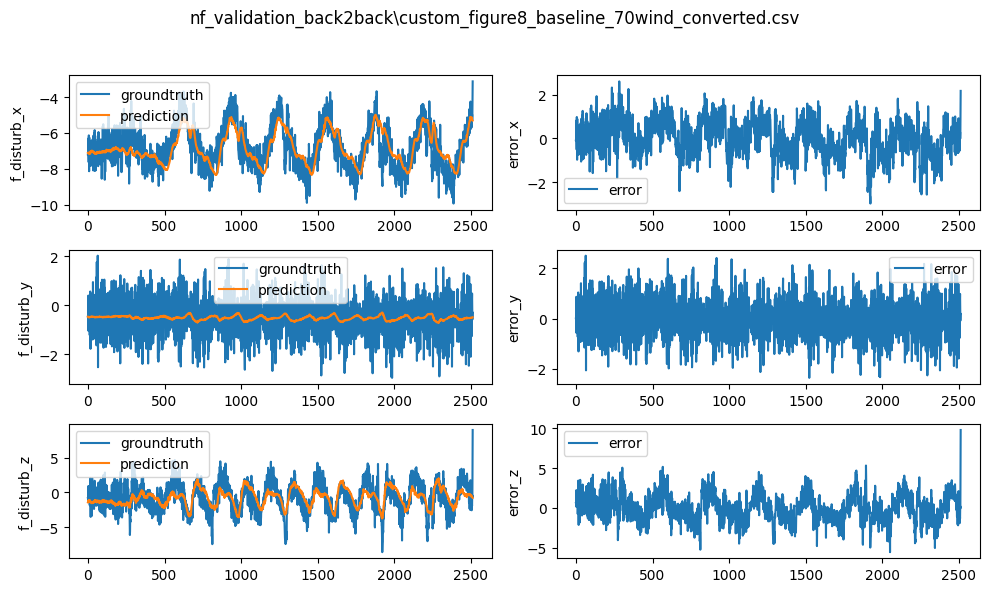

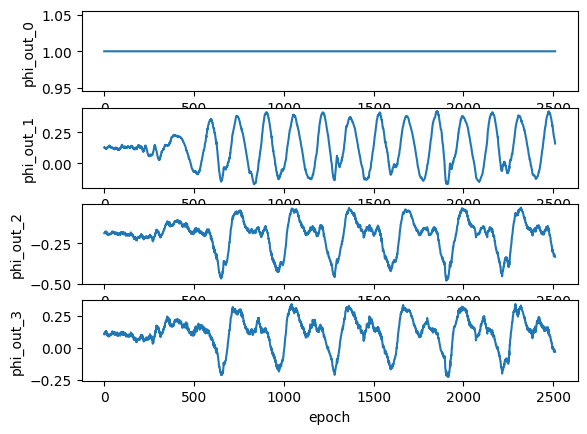

phi_out: tensor([[ 1.0000,  0.0586, -0.2084,  0.0723],
        [ 1.0000,  0.0662, -0.2091,  0.0705],
        [ 1.0000,  0.0784, -0.2095,  0.0697],
        ...,
        [ 1.0000,  0.0957, -0.3650, -0.0509],
        [ 1.0000,  0.0898, -0.3677, -0.0527],
        [ 1.0000,  0.0811, -0.3654, -0.0504]])
a = tensor([[-1.0029, -0.1695, -1.9148],
        [ 2.2967, -0.2588,  7.9871],
        [-7.1999,  0.9413, -5.0948],
        [ 2.8911, -0.8254,  5.2683]])


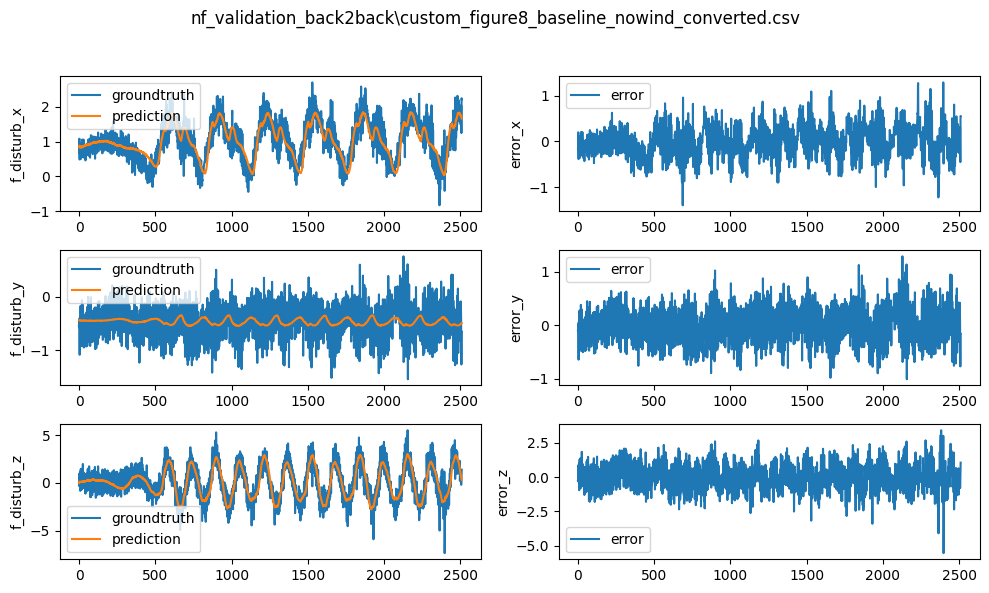

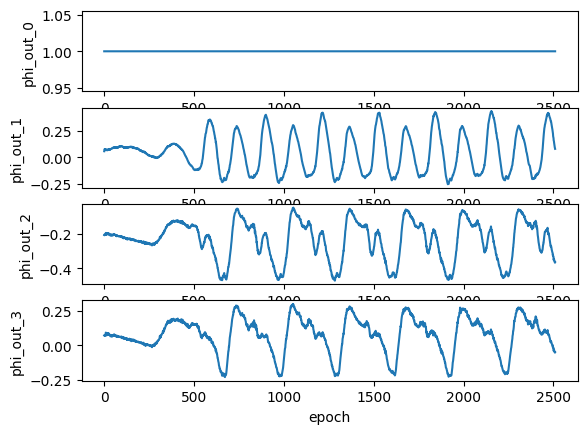

average rms for dim 0: 1.1714191538560859
average rms for dim 1: 0.5998160967777737
average rms for dim 2: 1.530748711482256


c:\YimingVirtualDDrive\7_workSpace\repo\neural-fly\Simulation\learning\validator.py:143: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


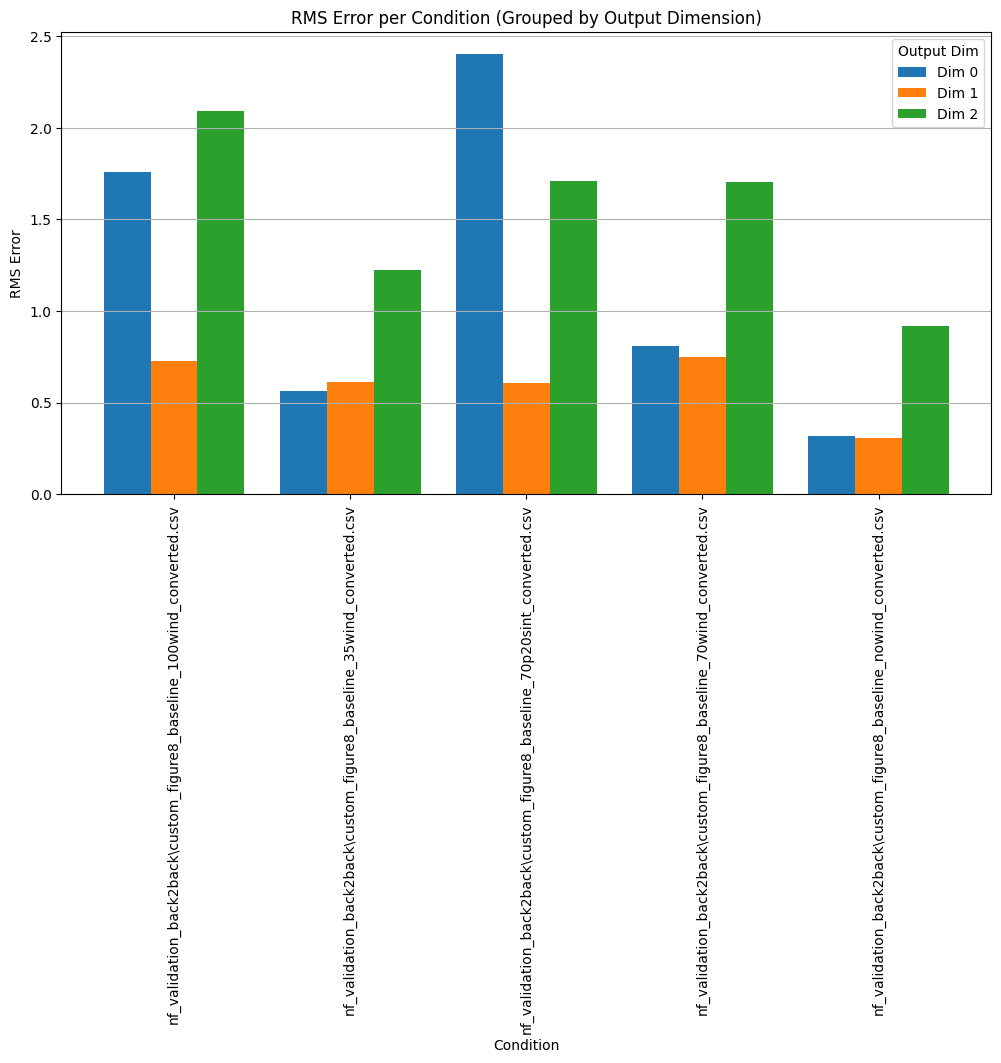

average mse for dim 0: 1.990697894300234
average mse for dim 1: 0.38468626226549374
average mse for dim 2: 2.512638255639961


c:\YimingVirtualDDrive\7_workSpace\repo\neural-fly\Simulation\learning\validator.py:169: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


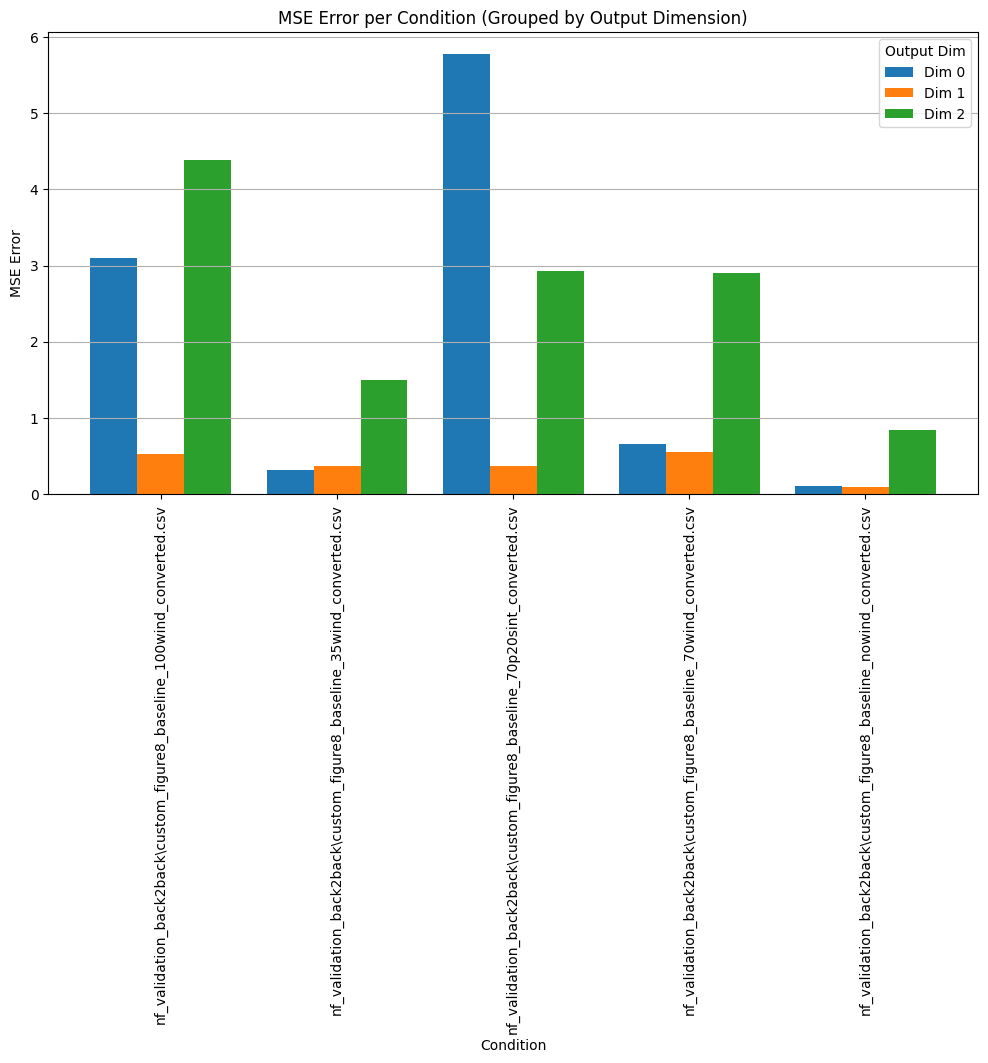

In [6]:
%matplotlib inline
model_name = training_subfolder

# subfolder = "wind_near_wall_validation_bemt"
# subfolder = "wind_near_wall_validation_no_bemt"
# subfolder = "wind_near_wall_bemt_in_control_train_xz_wind"
subfolder = "nf_validation_back2back"
data_list = generate_data_list(subfolder)
print("test Data List:")
for data in data_list:
    print(data)

# debug
# data_list = data_list[:1]  # use small data list for quick testing

manager = training_manager.TestManager()
manager.set_up(
    data_menu=data_list,
    input_label_map_file=path1,
    column_map_file=path2,
    can_skip_io_normalizaiton=False
)

phi, h = training_manager.load_model(model_name)
# make a new trainer to replicate the above setup, just to allow verify_model to work
manager.test(phi, h, data_list)
plt.show()  
